# Урок 5. Случайный лес

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import numpy as np

Воспользуемся алгоритмом случайного леса, представленным на лекции.

In [2]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [3]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [4]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity


# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [5]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [6]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [7]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [8]:
# Формирование случайного леса

def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [9]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [10]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [11]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

## Домашнее задание

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [12]:
classification_data, classification_labels = make_classification(n_samples=100,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, 
                                                                 random_state=21)

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=42)

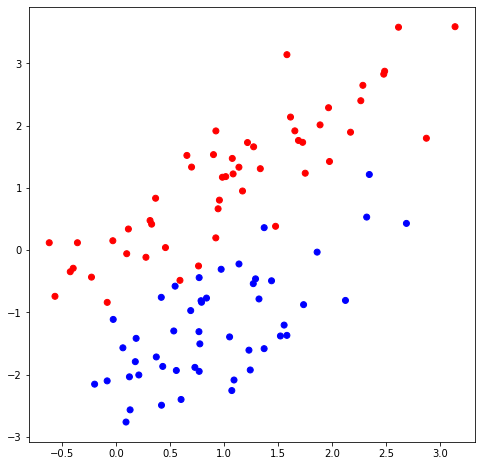

In [13]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [14]:
# Модифицируем функцию для визуализации результатов случайного леса

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, forest, train_accuracy, test_accuracy):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [15]:
def print_results(train_data, test_data, n_trees):
    forest = random_forest(train_data, train_labels, n_trees)
    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(forest, train_data)
    # И получим ответы для тестовой выборки
    test_answers = tree_vote(forest, test_data)

    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
    visualize(train_data, test_data, forest, train_accuracy, test_accuracy)

Точность случайного леса из 1 деревьев на обучающей выборке: 90.000
Точность случайного леса из 1 деревьев на тестовой выборке: 90.000


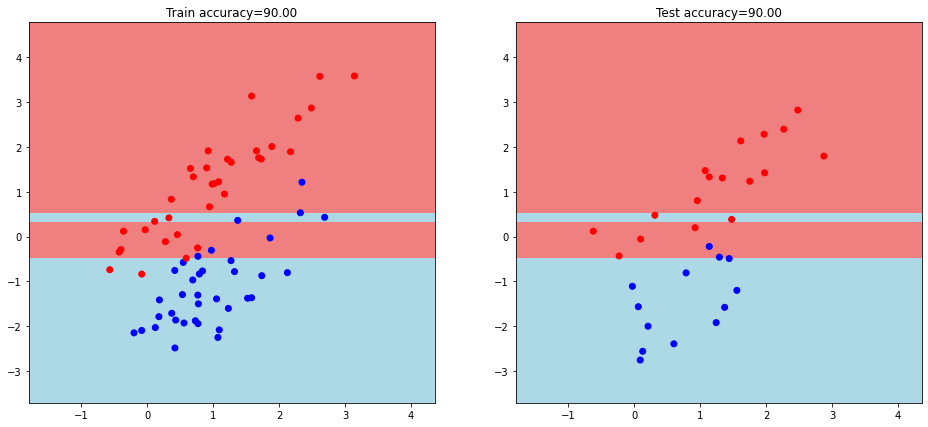

In [16]:
print_results(train_data, test_data, n_trees=1)

Точность случайного леса из 3 деревьев на обучающей выборке: 88.571
Точность случайного леса из 3 деревьев на тестовой выборке: 96.667


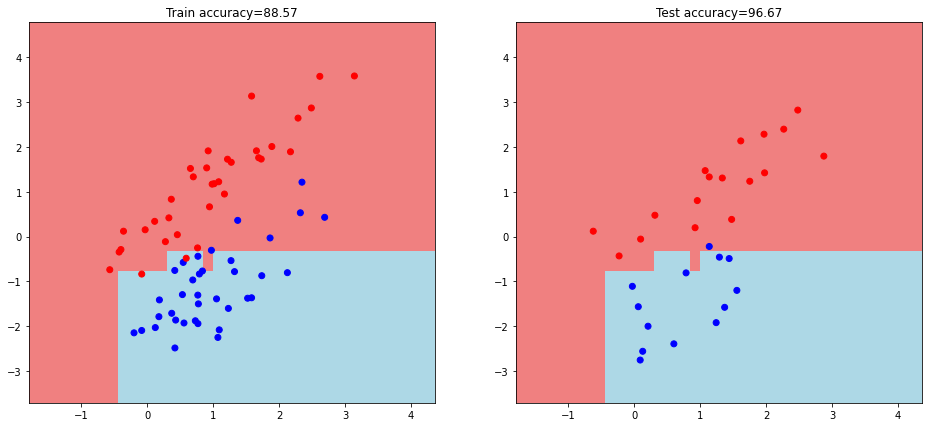

In [17]:
print_results(train_data, test_data, n_trees=3)

Точность случайного леса из 10 деревьев на обучающей выборке: 94.286
Точность случайного леса из 10 деревьев на тестовой выборке: 96.667


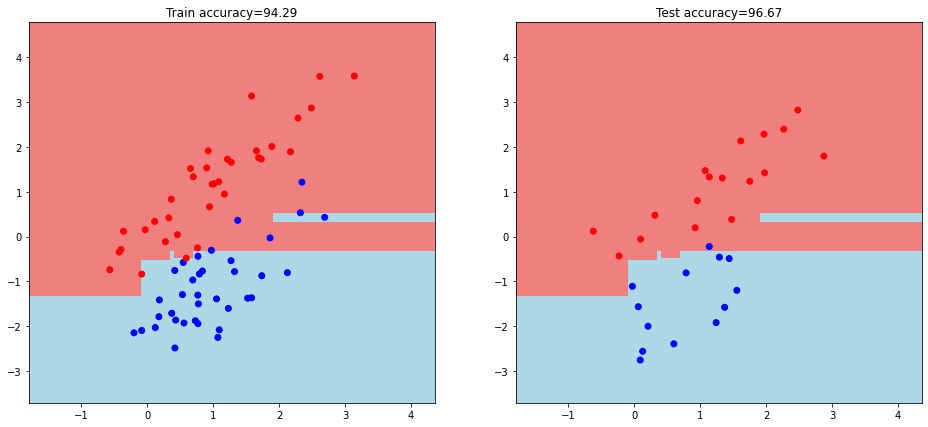

In [18]:
print_results(train_data, test_data, n_trees=10)

Точность случайного леса из 50 деревьев на обучающей выборке: 94.286
Точность случайного леса из 50 деревьев на тестовой выборке: 96.667


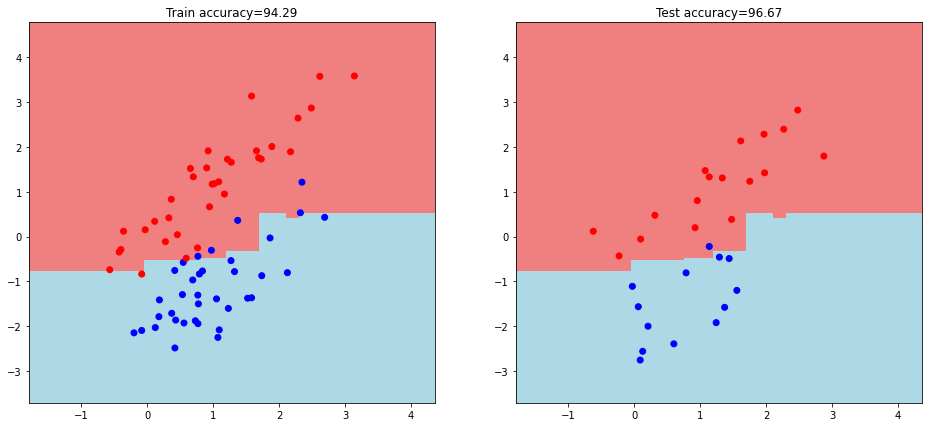

In [19]:
print_results(train_data, test_data, n_trees=50)

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

Как видим из полученных оценок, в данном случае нельзя говорить о каком-либо серьезном переобучении модели случайного леса, скорее наблюдается недообучение, т.к. результаты на тренировочном датасете оказались хуже, чем на тестовом для большинства моделей. Графическое представление разделяющих гиперплоскостей свидетельствует скорее о том, что проблема переобучения может быть актуальна для моделей, построенных на небольшом количестве деревьев. С ростом количества деревьев в лесу потенциальное переобучение исчезает.

3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [20]:
np.random.seed(21)

def get_bootstrap_oob(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        # Будем передавать вместе с выборкой индексы элементов, которые попали в эту выборку
        bootstrap.append((b_data, b_labels, np.unique(sample_index)))
        
    return bootstrap

In [21]:
# Создадим функцию, которая будет формировать случайный лес и оценивать oob_score

def random_forest_oob(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap_oob(data, labels, n_trees)
    n_samples = data.shape[0]
    
    # Создадим массив для записи предсказаний на неиспользованных при бутстрэпе наблюдениях
    predictions = list([list() for _ in range(n_samples)])
    
    for b_data, b_labels, sample_index in bootstrap:
        # Создаем дерево и добавляем его в лес
        tree = build_tree(b_data, b_labels)
        forest.append(tree)
        
        # Делаем предсказание дерева на наблюдениях, которые не попали в бутстрэп выборку для обучения
        test_index = np.setdiff1d(range(n_samples), sample_index)
        test_data = data[test_index]
        prediction = predict(test_data, tree)
        
        # Добавляем полученные предсказания в общий массив
        for k, j in enumerate(test_index):
            predictions[j].append(prediction[k])
            
    # 1. Пройдем по наблюдениям, для которых было хоть одно предсказание
    # 2. Определим конечное предсказание голосованием    
    # 3. Вычислим долю правильных предсказаний - oob_score
    
    correct_predictions = 0
    total_predictions = 0
    
    for i in range(n_samples):
        obj = predictions[i]
        if obj:
            total_predictions += 1
            if max(set(obj), key=obj.count) == labels[i]: 
                correct_predictions += 1 

    oob_score = correct_predictions/total_predictions
        
    return forest, oob_score

In [22]:
n_trees = 50
forest, oob_score = random_forest_oob(classification_data, classification_labels, n_trees)
print(f'OOB score для случайного леса из {n_trees} деревьев ' 
      f'при проверке с помощью отложенной выборки на Out-of-Bag - {oob_score}.')

OOB score для случайного леса из 50 деревьев при проверке с помощью отложенной выборки на Out-of-Bag - 0.89.


Сравним с результами, которые получаются при использовании инструментов `sklearn`.

In [23]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, bootstrap=True, oob_score=True,
                               max_features="sqrt",
                               random_state=21)

clf.fit(classification_data, classification_labels)

RandomForestClassifier(max_features='sqrt', n_estimators=50, oob_score=True,
                       random_state=21)

In [24]:
clf.oob_score_

0.89

4. *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

In [25]:
# Расчет энтропии Шэннона

def entropy(labels):
    p_values = np.array([labels[labels == label].shape[0]/labels.shape[0] for label in np.unique(labels)]) 
    entropy = np.sum(-p_values * np.log2(p_values))
        
    return entropy

In [26]:
labels = np.array([0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2])
entropy(labels)

1.5574319619297041

In [27]:
from scipy.stats import entropy as shannon_entropy
p_values = np.array([labels[labels == label].shape[0]/labels.shape[0] for label in np.unique(labels)])
shannon_entropy(p_values, base=2)

1.5574319619297043